# Project Details:

* Title: Reboot: Box-Plots for Education
* Team Members: **Ayesha Bhimdiwala**, Janaki Khatiwada, Sunanda Unni

# Introduction

The **Reboot: Box-Plots for Education** is a data science challenge sponsored by the Education Resource Strategies (ERS). It is an on-going competition which will end in February. 

In this project, we plan to solve a **multi-class-multi-label classification problem** with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.




##  Project Problem

Predict the probability that a certain label from each target category is attached to a budget line item.

## Data  Description

Train data set, "train.csv" has 25 features. Out of these, 2 are numerical and rest are categorical. Also out of 25, 9 are target features.

Following are the features that will be used for building model and predicting probabilities.

  *  FTE float - If an employee, the percentage of full-time that the employee works.
  *  Facility_or_Department - If expenditure is tied to a department/facility, that department/facility.
  *  Function_Description - A description of the function the expenditure was serving.
  *  Fund_Description - A description of the source of the funds.
  *  Job_Title_Description - If this is an employee, a description of that employee's job title.
  *  Location_Description - A description of where the funds were spent.
  *  Object_Description - A description of what the funds were used for.
  *  Position_Extra - Any extra information about the position that we have.
  *  Program_Description - A description of the program that the funds were used for.
  *  SubFund_Description - More detail on Fund_Description
  *  Sub_Object_Description - More detail on Object_Description
  *  Text_1 - Any additional text supplied by the district.
  *  Text_2 - Any additional text supplied by the district.
  *  Text_3 - Any additional text supplied by the district.
  *  Text_4 - Any additional text supplied by the district.
  *  Total float - The total cost of the expenditure.

And these are target features we have to predict probability for labeling each row.

  *  Function
  *  Object_Type
  *  Operating_Status
  *  Position_Type
  *  Pre-K
  *  Reporting
  *  Sharing
  *  Student_type
  *  Use


# ETL Phase

## Prepare the notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.utils import check_array
from time import time

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#from fancyimpute import MICE
from statsmodels.imputation.mice import MICEData as md
%matplotlib inline   

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from MICE import MiceImputer
import re
from sklearn import preprocessing

In [4]:
%ls -l data/education_reboot/TrainingData.csv

-rwxrwxrwx 1 1000 1000 124760056 Nov 10 22:05 data/education_reboot/TrainingData.csv*


In [5]:
path = os.path.join('data','education_reboot') #make sure you have the same path in your parent directory
path

'data/education_reboot'

### Load the data

In [6]:
def load_data(datapath,data):
    csv_path = os.path.join(datapath,data)
    df = pd.read_csv(csv_path)
    #df = pd.read_csv(csv_path,index_col=0)
    
  #  print(df.info())
  #  display(df.head())
  #  print()
    return df

In [7]:
train = load_data(path,"TrainingData.csv")
train['index'] = train['Unnamed: 0']

In [9]:
train = train.drop('Unnamed: 0', axis = 1)
train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN,326408
3,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


In [10]:
train = train.drop_duplicates('index')
train.shape

(400277, 26)

Looking at the column names i.e. our features, we see there are **Two** numeric features, FTE and TOTAL.

* FTE stands for full-time equivalent(0-100%). To elaborate, if a budget item is associated to an employee, then we have a value between 0 and 1. It tells us the percentage of full-time that the employee works. A value of 1 means the employee works full-time. A value close to 0 means the employee is working either part-time or on contract basis.

* TOTAL stands for the total cost of the expenditure. It tells us how much the budget item costs.



## Exploratory Data Analysis
**Let's explore numeric variables further:**

In [9]:
train.describe()

,FTE,Total,index
count,126071.000000,3.957220e+05,400277.000000
mean,0.426794,1.310586e+04,225186.018537
std,0.573576,3.682254e+05,130025.142718
min,-0.087551,-8.746631e+07,2.000000
25%,0.000792,7.379770e+01,112601.000000
50%,0.130927,4.612300e+02,225243.000000
75%,1.000000,3.652662e+03,337722.000000
max,46.800000,1.297000e+08,450340.000000


We see there are some negative values in the the numeric features. We would have to impute such missing or incorrect values as we cannot have a negative value associated with the percentage of full-time that the employee works or total cost of the expenditure.

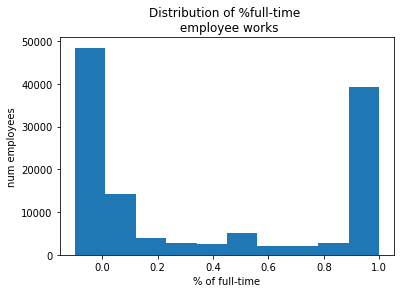

In [10]:
plt.hist(train['FTE'].dropna(),range=[-0.1,1])
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

From the above plot, we can see that our budgets data favors part-time and contract-based employees as we have more contract employees than full-time employees. 

We have 50k records with negative FTE. Ideally it shouldn’t be negative. This shows that a lot of positions are getting changed and thus resulting in **negative** values. Our strategy would be to normalizing it to 0.

We can assume that contract-based employees are hired for a short-term purpose and that is why they need certain items more frequent than full-time employees who would have such items easily accessible. (NEED to INFER something!)

### Distribution of Categorical Features

Since this data set primarily consists of categorical features, it is very important to look at their distribution. The table below show unique values, count of features, top feature and frequency of top subcategory under each category.

In [11]:
train.describe(include=['O'])

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
count,400277,400277,400277,400277,400277,400277,400277,400277,400277,375493,...,109152,53746,91603,162054,342195,53886,264764,304660,202877,292285
unique,37,8,5,3,9,25,11,3,3,602,...,34,244,182,354,687,179,580,421,141,1423
top,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,Regular,Regular Instruction,Extra Duty Pay/Overtime For Support Personnel,School,NON-PROJECT,All Campus Payroll,PROFESSIONAL-INSTRUCTIONAL,GENERAL ELEMENTARY EDUCATION,General Operating Fund,REGULAR INSTRUCTION
freq,86354,203608,254433,257258,223026,102788,97670,306425,343578,47495,...,94462,10762,9159,65524,76890,17697,92136,32829,33467,64896


 Let us look at null values under each category

In [12]:
print(train.isnull().sum())

Function                       0
Use                            0
Sharing                        0
Reporting                      0
Student_Type                   0
Position_Type                  0
Object_Type                    0
Pre_K                          0
Operating_Status               0
Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
FTE                       274206
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Total                       4555
Program_Description        95617
Fund_Description          197400
Text_1                    107992
index                          0
dtype: int64


Converting our Categorical columns datatype from object to categorical, as this will help in the future for pipeline

In [11]:
### post numerical pipeline changes need to check if we can remove these variables, 
### used 3 cells below

cat_list = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type',
              'Pre_K','Operating_Status']

In [14]:
# cat_lab = lambda x: x.astype('category')

# train[cat_list] = train[cat_list].apply(cat_lab,axis=0)

# print(train.dtypes)

In [15]:
np.round(np.sum(train['Total'] < 0)/np.sum(train['Total']),6)

8e-06

So, we see that we have a small percent of negative budgets. Look’s good for now. Later we will impute them.

**Let's see the sub-categories of our target classes**

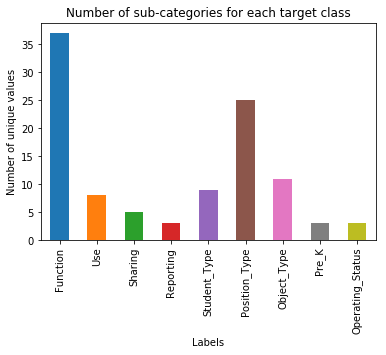

In [16]:
import matplotlib.pyplot as plt

uni_labels = train[cat_list].apply(pd.Series.nunique)

uni_labels.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number of sub-categories for each target class')

plt.show()

From the above plot, we see that Function and Position_Type have the highest number of sub-categories while the lowest number of sub-categories are 3 in Operating_Status, Pre_K, and Reporting.

In [2]:
# Let's see if missing Total can be computed based on Job_Title_Description
#average_total =train[['Total', 'Job_Title_Description']].groupby(['Job_Title_Description'], as_index = True).mean().sort_values(by = 'Total')

Let us further explore how the Budget is distributed among different target class

<function matplotlib.pyplot.show>

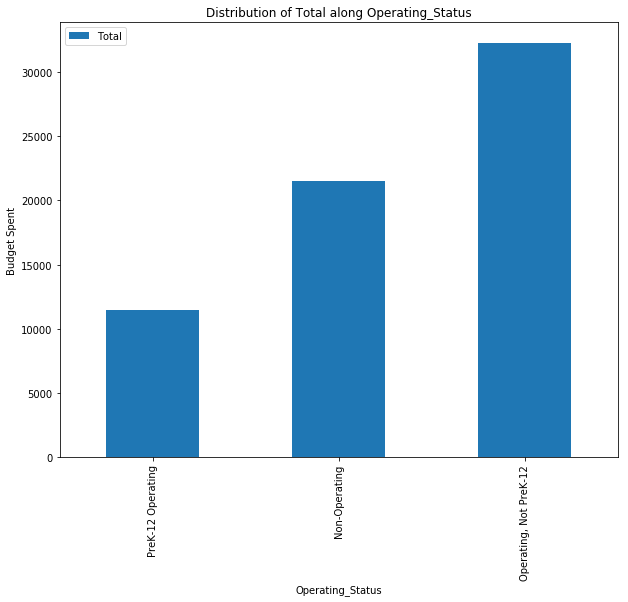

In [18]:
average_total=train[['Total', 'Operating_Status']].groupby(['Operating_Status'], as_index = True).mean().sort_values(by = 'Total')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Total along Operating_Status')
plt.ylabel('Budget Spent')
plt.show

From the above plot we can see that our Budget is highly skewed to the Operating, Not PreK-12 sub-category compared to the rest of the sub-categories.

<function matplotlib.pyplot.show>

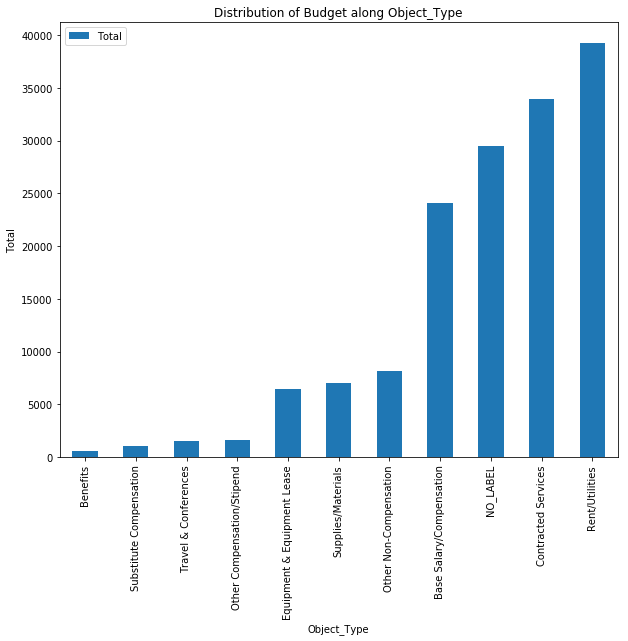

In [19]:
average_total=train[['Total', 'Object_Type']].groupby(['Object_Type'], as_index = True).mean().sort_values(by = 'Total')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Budget along Object_Type')
plt.ylabel('Total')
plt.show

<function matplotlib.pyplot.show>

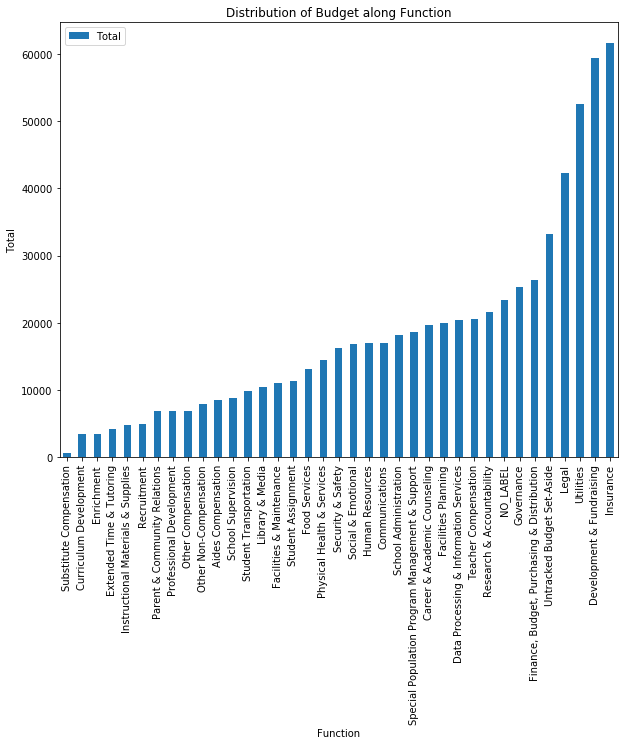

In [20]:
ave_total_func=train[['Total', 'Function']].groupby(['Function'], as_index = True).mean().sort_values(by = 'Total')
ave_total_func.plot.bar(figsize= (10,8))
plt.title('Distribution of Budget along Function')
plt.ylabel('Total')
plt.show

From the above plot, we can see that most of the school budget is spent on the Insurance, Development & Fundraising, Utilities, and Legal activities. Among these, Utilities is the only one that may directly affect the student learning experience. We can see that curriculum development, extended time and tutoring have the least budget spent. 
ERS (our host), really needs to focus on guiding its financial partners to understand their budget spent. We say so, as our host wants to improve student and teacher outcomes as well. 

# Preparing the Code for ML algorithm

## Supporting Classes

### Multitrain test split


Since we are dealing with a multilabel, multiclass situation, we are going to split our training data set in a multi-stratified way. By that we mean we want to make sure all of our sub-categories are present in train and test set. 
If we don't use this custom train-test-split, we may run into issues where our train data has never seen some of the sub-categories and we know that this cannot be the case because we are performing supervised learning.

In [2]:
#source: https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


### DataFrameSelector class

In [13]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

### Numerical to Categorical class

### Evaluate micro and macro scores

In [14]:
# Call Evaluate with parameters
# test_labels :True value
# predictions :Predicted value
# Returns: 6 values : micro precision, micro recall, micro f1, macro precision, macro recall, macro f1
from sklearn.metrics import f1_score, precision_score, recall_score
#Multi-labels per example evaluation
def evaluate(test_labels, predictions):
    precision = np.round(precision_score(test_labels, predictions, average='micro'),3)
    recall = np.round(recall_score(test_labels, predictions, average='micro'),3)
    f1 = np.round(f1_score(test_labels, predictions, average='micro'),3)
    print("Micro-average quality numbers")
    print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(precision, recall, f1))

    macro_precision = np.round(precision_score(test_labels, predictions, average='macro'),3)
    macro_recall = np.round(recall_score(test_labels, predictions, average='macro'),3)
    macro_f1 = np.round(f1_score(test_labels, predictions, average='macro'),3)

    print("Macro-average quality numbers")
    print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(macro_precision, macro_recall, macro_f1))
    
    return precision, recall, f1, macro_precision, macro_recall, macro_f1
    


### write_predict_tocsv - Creating Submission csv file

In [15]:
# This function converts prediction probability ndarray to a csv file
def write_predict_tocsv(predict_array, csvfilename, columnname_list, index_array):
    np_pred = np.array(predict_array)
    np_pred_t = np_pred.T[1]
    df = pd.DataFrame(np_pred_t, columns=columnname_list, index=index_array)    
    df.to_csv(csvfilename)
    
    

## Target feature Pipeline

Our target feature should be as 104 categories to make predictions

In [16]:
class TargetExpander(BaseEstimator, TransformerMixin):
    def __init__(self, cat_list): 
        self.cat_list = cat_list
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.X = pd.DataFrame(X, columns=self.cat_list,dtype=object)
        self.X = pd.get_dummies(self.X[cat_list])
        
        #return np.array(self.X.values)
        return self.X

In [17]:
# use full pipeline above to build full pipeline with predictor
cat_list = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type',
              'Pre_K','Operating_Status']
target_pipeline =  Pipeline([
        ('selector', DataFrameSelector(cat_list)),
        ('expand', TargetExpander(cat_list))
    ])

target_pipeline.fit(train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'])), ('expand', TargetExpander(cat_list=['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']))])

* target_104_data is the target features, our 'y'.

In [18]:
target_104_data = target_pipeline.transform(train)
target_104_data.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


# Splitting the data

https://www.researchgate.net/post/Should_Indepenent_variables_be_more_than_the_dependent_variables


In [19]:
X_train, X_other, y_train, y_other = multilabel_train_test_split(train,target_104_data,
                                                               size=np.floor(len(target_104_data)* 0.5)
                                                                 ,seed=143,
                                                                min_count=10)

In [20]:
X_test, X_validate, y_test, y_validate = multilabel_train_test_split(X_other,y_other,
                                                               size=np.floor(len(y_other)* 0.5),
                                                            seed=143,
                                                                min_count=10)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)

(200139, 26)
(100069, 26)
(100069, 26)


#  Numerical Pipeline using MICE

* To handle the null values in the numeric data, we had created a customized imputer function that was imputing the missing FTE and Total (Budget spent) based on sub-categories in our training set.
* On some research, we found a code that is inspired by SKlearn statsmodel library, [MICE module](http://www.statsmodels.org/dev/imputation.html#).
* [MICE.py](https://github.com/jeweinberg/Pandas-MICE) that we will implement in Phase 2 of our Final project.

MICE stands for Multiple Imputation with Chained Equations. We know that FTE and Total Budget are document specific, i.e. a full-time employee and a higher paid employee would not have the same role, designation, operation status, etc as a part-time employee hired on a contract basis. We cannot impute them by taking a mean or median of the entire dataset. Hence, we need a special imputation method that can use as much information as possible from the other features (independent variables) to impute depending on each document (employee) feature. 

## Wrapper for Imputation

* Imputation using MICE and Scaled using MinMax

In [22]:
class SelfImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputed_attrib_names, attrib_names, datatype, seed_strategy='most_frequent'):
        ## seed_strategy : strategy for imputation, set to 'most_frequent' as default
        ## imputed_attrib_name : columns which should be picked from the imputed data, here 'FTE' & 'TOTAL'. 
        ##                           Rest will be used for imputation however we should return the df 
        ##                               with only imputed_attrib_name columns changed
        
        self.imputed_attrib_names = imputed_attrib_names
        self.attrib_names = attrib_names
        self.seed_strategy = seed_strategy
        self.datatype = datatype
        ##self.attrib_names.append('index')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Create a copy of the input df to work with
        self.X = pd.DataFrame(X, columns=self.attrib_names, dtype=object)
        self.X.FTE = self.X.FTE.astype(float)
        self.X.Total = self.X.Total.astype(float)
        self.X['index'] = pd.to_numeric(self.X['index'])
    
        
        #print(self.X.info())
        #temporary df- need not remove if no time
        self.X_imp = self.X.copy()
        
        mice_imp = MiceImputer(seed_strategy=self.seed_strategy)
        le = preprocessing.LabelEncoder()
        for column_name in self.X_imp.columns:
            if self.X_imp[column_name].dtype == object:
              #  removing characters other than alphabets
                temp = self.X_imp[column_name].astype(str).map(lambda x: re.sub(r'\W+', '', x))        
                self.X_imp[column_name] = le.fit_transform(temp)
            else:
                pass
        #print(self.X_imp.info())
        #fit the model for imputation
        # transform the copy of input df and imput missing 
        miced_data_in = mice_imp.fit(self.X_imp).transform(self.X_imp)
        miced_data_np = MinMaxScaler().fit_transform(miced_data_in[['FTE','Total']])
        miced_data = pd.DataFrame(miced_data_np,columns=['FTE','Total'])
        miced_data['index'] = miced_data_in['index']
        ## Reconstructing the input df with only the imputed_attrib_names columns changed
        
        self.X = self.X.drop(columns=self.imputed_attrib_names)#['FTE','Total'])  # drop 'FTE' and 'Total'
       # print(self.X.info())
        
        self.imputed_attrib_names.append('index') # need to extract 'FTE', 'Total' and 'index' columns from imputed data
        miced_data_subset = miced_data[self.imputed_attrib_names]#['FTE','Total','index']]
        #print (miced_data_subset.info())
        self.X = pd.merge(self.X,miced_data_subset,how='outer', on='index')
        #print(self.X.head())
        return miced_data_subset 
    


## Create pipeline for MICE imputation

In [23]:
num_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description','FTE',
                      'Function_Description','Facility_or_Department','Position_Extra','Total',
                      'Program_Description','Fund_Description','Text_1','index']
num_impute_attribs = ['FTE','Total']
datatype = np.dtype([('Object_Description',object),('Text_2',object),('SubFund_Description',object),('Job_Title_Description',object),('Text_3',object),('Text_4',object),('Sub_Object_Description',object),('Location_Description',object),('FTE',float),('Function_Description',object),('Facility_or_Department',object),('Position_Extra',object),('Total',float),('Program_Description',object),('Fund_Description',object),('Text_1',object),('index',int)])

num_impute_pipeline =  Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SelfImputer(num_impute_attribs,num_attribs,datatype,seed_strategy="most_frequent"))
     ])


## Test Numerical Imputer pipeline

In [24]:
num_impute_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Object_Description', 'Text_2', 'SubFund_Description', 'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description', 'Location_Description', 'FTE', 'Function_Description', 'Facility_or_Department', 'Position_Extra', 'Total', 'Program_De...), ('index', '<i8')]),
      imputed_attrib_names=['FTE', 'Total'], seed_strategy='most_frequent'))])

In [25]:
train_num_imp = num_impute_pipeline.transform(X_train)

In [26]:
# run only if column index not unique
#X_test = X_test.drop_duplicates('index') 

In [26]:
num_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description','FTE',
                      'Function_Description','Facility_or_Department','Position_Extra','Total',
                      'Program_Description','Fund_Description','Text_1','index']
num_impute_attribs = ['FTE','Total']
datatype = np.dtype([('Object_Description',object),('Text_2',object),('SubFund_Description',object),('Job_Title_Description',object),('Text_3',object),('Text_4',object),('Sub_Object_Description',object),('Location_Description',object),('FTE',float),('Function_Description',object),('Facility_or_Department',object),('Position_Extra',object),('Total',float),('Program_Description',object),('Fund_Description',object),('Text_1',object),('index',int)])

num_impute_pipeline2 =  Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SelfImputer(num_impute_attribs,num_attribs,datatype,seed_strategy="most_frequent"))
    ])

num_impute_pipeline2.fit(X_test)
test_num_imp = num_impute_pipeline2.transform(X_test)


In [27]:
train_num_imp.head()

,FTE,Total,index
0,0.036516,0.646563,134338
1,0.011385,0.646191,364634
2,0.018327,0.646205,417668
3,0.012095,0.646192,275539
4,0.027874,0.646190,330504


# Categorical pipeline

Create the additional column "All" joining all the Categorical columns 

## CategoricalImputer class for feature engineering

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self,cat_attribs):
        self.cat_attribs = cat_attribs
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.X = pd.DataFrame(X, columns=self.cat_attribs, dtype=object)
        self.X = self.X.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
        self.X['index'] = pd.to_numeric(self.X['index'])
        #temporary df - not to remove unless we have time to test
        #self.X_tmp = self.X.copy()
        
        All = self.X[self.X.drop(columns=['index']).columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        print(All.sort_index().head())
        
        self.X["All"] = All
        self.X = self.X[["All", "index"]]
        
        return self.X
        
        

## Creating the Categorical Pipeline

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
cat_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description',#'FTE',
                      'Function_Description','Facility_or_Department','Position_Extra',#'Total',
                      'Program_Description','Fund_Description','Text_1','index'] 
cat_pipeline = Pipeline([
            ('selector',DataFrameSelector(cat_attribs)),
            ('imputer', CategoricalImputer(cat_attribs))
            
            ]
            )

### test CategoricalImputer

In [30]:
cat_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Object_Description', 'Text_2', 'SubFund_Description', 'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description', 'Location_Description', 'Function_Description', 'Facility_or_Department', 'Position_Extra', 'Program_Description', 'Fun...y_or_Department', 'Position_Extra', 'Program_Description', 'Fund_Description', 'Text_1', 'index']))])

In [31]:
train_imp = cat_pipeline.transform(X_train)

0    nan nan nan Teacher-Elementary nan nan nan nan...
1    EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND Te...
2    EDUCATIONAL SPECIAL EDUCATION INSTRUCTION LOCA...
3    EMPLOYEE BENEFITS nan GENERAL FUND Teacher, El...
4    SUPPLIES nan PRIMARY GRADES PROGRAM nan nan na...
dtype: object


In [32]:
train_imp.shape

(200139, 2)

In [33]:
test_imp = cat_pipeline.transform(X_test)

0    CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
1    Personal Services - Teachers nan nan TCHER 2ND...
2    EMPLOYEE BENEFITS nan GENERAL FUND Sub Manager...
3    EQUIPMENT * nan Support Services - Administrat...
4    Non-Certificated Travel Reimbursement nan Supp...
dtype: object


In [34]:
test_imp.shape

(100069, 2)

### Vectorize the "All" column

In [35]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["nan", "n/a"])
#vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')
vect = TfidfVectorizer(sublinear_tf=True, max_df=1, analyzer='word', stop_words=my_stop_words)
X = vect.fit_transform(train_imp["All"])

In [36]:
X_test = vect.transform(test_imp["All"]) #transforming test based on train fitted method

In [37]:
X.data[:10]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.70710678, 0.70710678])

In [38]:
# for train
cat_tok = pd.SparseDataFrame(X, columns=vect.get_feature_names(), default_fill_value=0)
cat_tok.shape

(200139, 496)

In [39]:
# for test
cat_tok_test = pd.SparseDataFrame(X_test, columns=vect.get_feature_names(), default_fill_value=0)
cat_tok_test.shape

(100069, 496)

In [40]:
cat_tok.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 200139 entries, 0 to 200138
Columns: 496 entries, 60 to zoo
dtypes: float64(496)
memory usage: 4.0 KB


In [63]:
cat_tok.head()

,60,70hr,80hs,acadmey,accident,accompanists,achiev,actually,adapted,addtn,...,wf,williams,worke,works,workstudy,wrkr,xerox,xmas,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#cat_tok = cat_tok.drop_duplicates(['index'])
#cat_tok.shape
cat_tok.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 200139 entries, 0 to 200138
Columns: 496 entries, 60 to zoo
dtypes: float64(496)
memory usage: 4.0 KB


In [41]:
'accompanists' in cat_tok.keys() # checking for a key

True

# Merge Numerical and Categorical Pipeline by merging

## Train merge

In [42]:
prepared_data = pd.concat([train_num_imp, cat_tok], axis=1, join_axes=[cat_tok.index])
prepared_data.shape

(200139, 499)

In [43]:
prepared_data.head()

,FTE,Total,index,60,70hr,80hs,acadmey,accident,accompanists,achiev,...,wf,williams,worke,works,workstudy,wrkr,xerox,xmas,zone,zoo
0,0.036516,0.646563,134338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.011385,0.646191,364634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018327,0.646205,417668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012095,0.646192,275539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.027874,0.646190,330504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test merge

In [44]:
prepared_test_data = pd.concat([test_num_imp, cat_tok_test], axis=1, join_axes=[cat_tok_test.index])
prepared_test_data.shape

(100069, 499)

https://www.researchgate.net/post/Should_Indepenent_variables_be_more_than_the_dependent_variables


# Feature Importances

Now we will look at feature importance for each of our features. For this we are using RandomForestClassifier from sklearn.ensemble. For this purpose, we are using unsplitted data set with independent features and also unsplitted labels.

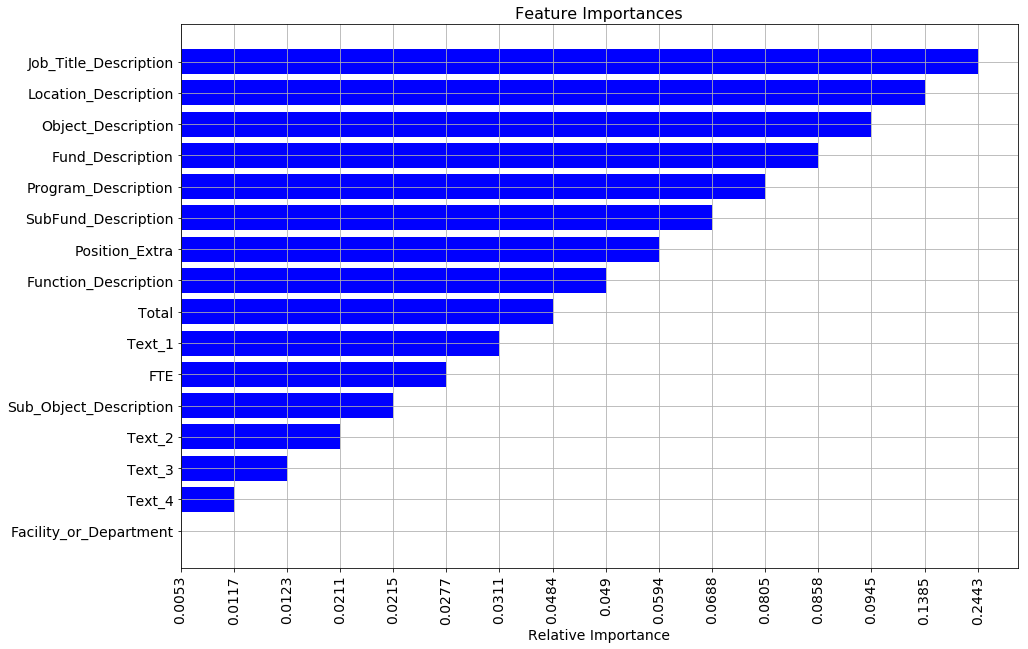

Looking at the output of feature imporatnces and also barplot we can see that Job_Description has the highest coefficient( 0.244), followed by Location_Description, Object_description, Fund_description, Program_Description and so on. Facility or Department is the least important feature of all. 

# Classification Model

https://stackoverflow.com/questions/26018543/gridsearch-for-multi-label-classification-in-scikit-learn <br>
http://lpis.csd.auth.gr/publications/sechidis-ecmlpkdd-2011.pdf


## Logging the Result

In [51]:
results = pd.DataFrame(columns=["Model", "Parameters",  "Micro Precision", "Micro Recall","Micro F1 Score","Macro Precision", "Macro Recall","Macro F1 Score","Runtime"])

## MultiClass MultiLabel Classification Models

### MultiOutput Linear SVC

<b>
    Linear Kernel SVM for classification is implemented in sklearn via the class LinearSVC
    
    OneVsAll: train K classifiers: a binary classifier for each class, with the samples of that class as positive samples and all other samples as negatives. For prediciton choose the class whose classifier outputs the largest value.
 </b>

In [45]:
from sklearn.multioutput import MultiOutputClassifier

start = time.time()


from sklearn.svm import LinearSVC
svc_classifier = Pipeline([
  #  ('tfidf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')),
  #  ('clf', MultiOutputClassifier(LinearSVC()))
     ('clf', MultiOutputClassifier(LinearSVC()))
    
    ])

runtime = time.time()- start

In [46]:
prepared_data.shape
y_train.shape

(200139, 104)

In [47]:
svc_classifier.fit(prepared_data, y_train)

Pipeline(memory=None,
     steps=[('clf', MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
           n_jobs=1))])

In [48]:
predicted = svc_classifier.predict(prepared_test_data)

In [49]:
precision, recall,f1, macro_precision, macro_recall, macro_f1 = evaluate(y_test, predicted)

Micro-average quality numbers
Precision: 0.249, Recall: 0.218, F1-measure: 0.232
Macro-average quality numbers
Precision: 0.033, Recall: 0.073, F1-measure: 0.027


In [53]:
results.loc[len(results)] = ["MultiOutputClassifier(LinearSVC)", "C=1.0,penalty=l2,dual=True",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]


In [54]:
results

,Model,Parameters,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
1,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004


* The model has performed..

### MultiOutput with RandomForest Classifier

In [88]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [89]:
fit_model = multi_target_forest.fit(prepared_data, y_train)

In [135]:
from sklearn.externals import joblib
joblib.dump(fit_model, 'MO_randomForest.pkl') 

['MO_randomForest.pkl']

In [ ]:
 # in future
    #clf = joblib.load('filename.pkl') 

In [83]:
MO_randomForest_pred = fit_model.predict_proba(prepared_test_data)

In [ ]:
write_predict_tocsv(MO_randomForest_pred, 'ran_for_sub.csv', target_104_data.columns, 
                    index=prepared_test_data.index)

In [194]:
# print(np.sum(MO_randomForest_pred[:][1][:]))
# for i in MO_randomForest_pred[:1]:
#     print(np.ndarray.sum(i[:,1]))
# #print(sum)
# np_pred[:][1][1]

84058.0
4167.25


array([1., 0.])

In [186]:
np_pred = np.array(MO_randomForest_pred)
np_pred.data.ndim

3

In [201]:
np_pred[0][0][1]

0.0

In [213]:
np_pred_t = np_pred.T[1]

In [ ]:
## write predict to write csv function for submission
# para1 : nd_arr_pred 
# para2: csv file name

In [219]:
type(np_pred_t)

numpy.ndarray

In [222]:
df = pd.DataFrame(np_pred_t)
df.to_csv("submission.csv",header=target_104_data.columns)

In [91]:
results.loc[len(results)] = ["MultiOutputClassifier(RandomForest)", "alpha=0.0001,penalty=l2",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]

,Model,Hyper parameter tuning,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier - SGD(Log Loss),"alpha=0.0001,penalty=l2",0.4241,0.4596,0.4411,0.0969,0.0931,0.0594,7.08s


### MultiOutputClassifier - SGD Classifier

In [55]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import LinearSVC
sgd_clf = Pipeline([
  #  ('tfidf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')),
  #  ('clf', MultiOutputClassifier(LinearSVC()))
    ('clf', MultiOutputClassifier(SGDClassifier(loss='log')))
])

In [57]:
start = time.time()
sgd_clf.fit(prepared_data, y_train)

runtime = time.time() - start
sgd_predicted = sgd_clf.predict(prepared_test_data)

In [59]:
# predicted = classifier.predict(X_test)

precision, recall,f1, macro_precision, macro_recall, macro_f1 = evaluate(y_test, sgd_predicted)
results.loc[len(results)] = ["MultiOutputClassifier (SGD)", "alpha=0.0001,penalty=l2",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]
results

Micro-average quality numbers
Precision: 0.350, Recall: 0.506, F1-measure: 0.414
Macro-average quality numbers
Precision: 0.044, Recall: 0.125, F1-measure: 0.058


,Model,Parameters,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
1,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
2,MultiOutputClassifier (SGD),"alpha=0.0001,penalty=l2",0.350,0.506,0.414,0.044,0.125,0.058,298.7522


In [ ]:
## we need it as a baseline accuracy for t-test
baseline_modelscores = cross_val_score(classifier, x_train, y_train, cv=3)
logit_score_train = baseline_modelscores.mean()
train_time = np.round(time() - start, 4)

In [91]:
#results.loc[len(results)] = ["MultiOutputClassifier SGD(Log Loss)", "alpha=0.0001,penalty=l2",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]
#results

,Model,Hyper parameter tuning,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier - SGD(Log Loss),"alpha=0.0001,penalty=l2",0.4241,0.4596,0.4411,0.0969,0.0931,0.0594,7.08s


In [135]:
#predicted[:5]

In [200]:
for category in cat_list:
    LR_pipeline.fit(df_train['all'], df_train[category])
    prediction = LR_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, np.round(accuracy_score(df_val[category], prediction),2)))

Category Function : Test accuracy is 0.95
Category Use : Test accuracy is 0.96
Category Sharing : Test accuracy is 0.96
Category Reporting : Test accuracy is 0.97
Category Student_Type : Test accuracy is 0.97
Category Position_Type : Test accuracy is 0.97
Category Object_Type : Test accuracy is 0.98
Category Pre_K : Test accuracy is 0.99
Category Operating_Status : Test accuracy is 0.98


###  MultiOutput Classifier Logistic Regression 

In [62]:
## logistic regression as Baseline model
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
start = time.time()

logreg_clf = MultiOutputClassifier(LogisticRegression())


runtime = np.round(time.time()- start,4)

In [63]:
logreg_clf.fit(prepared_data, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1)

In [61]:
logreg_predicted = logreg_clf.predict(prepared_test_data)




In [64]:
precision, recall,f1, macro_precision, macro_recall, macro_f1 = evaluate(y_test, logreg_predicted)
results.loc[len(results)] = ["MultiOutputClassifier (Logistic Reg)", "C=1.0',penalty=l2, dual=False",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]
results

Micro-average quality numbers
Precision: 0.661, Recall: 0.441, F1-measure: 0.529
Macro-average quality numbers
Precision: 0.038, Recall: 0.058, F1-measure: 0.046


,Model,Parameters,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
1,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
2,MultiOutputClassifier (SGD),"alpha=0.0001,penalty=l2",0.350,0.506,0.414,0.044,0.125,0.058,298.7522
3,MultiOutputClassifier (Logistic Reg),"C=1.0',penalty=l2, dual=False",0.661,0.441,0.529,0.038,0.058,0.046,0.0031


In [65]:
logreg_probabs = logreg_clf.predict_proba(prepared_test_data)

In [68]:
write_predict_tocsv(logreg_probabs, "logregProbabs.csv", target_104_data.columns, prepared_test_data['index'])

In [66]:
prepared_test_data['index'][:5]

0    229958
1    417668
2     84272
3     64760
4    169914
Name: index, dtype: int64

### MultiOutputClassifier with estimator Multinomial Naive Bayes

In [67]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB

start = time.time()

mnb_clf = MultiOutputClassifier(MultinomialNB())


runtime = time.time()- start

In [68]:
mnb_clf.fit(prepared_data, y_train)

MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=1)

In [69]:
mnb_predicted = mnb_clf.predict(prepared_test_data)

In [72]:
precision, recall,f1, macro_precision, macro_recall, macro_f1 = evaluate(y_test, mnb_predicted)
results.loc[len(results)] = ["MultiOutputClassifier (MNB)", "alpha=1.0,class_prior=None, fit_prior=none",precision, recall,f1, macro_precision, macro_recall, macro_f1, np.round(runtime,4)]
results

Micro-average quality numbers
Precision: 0.659, Recall: 0.442, F1-measure: 0.529
Macro-average quality numbers
Precision: 0.185, Recall: 0.060, F1-measure: 0.050


,Model,Parameters,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
1,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
2,MultiOutputClassifier (SGD),"alpha=0.0001,penalty=l2",0.350,0.506,0.414,0.044,0.125,0.058,298.7522
3,MultiOutputClassifier (Logistic Reg),"C=1.0',penalty=l2, dual=False",0.661,0.441,0.529,0.038,0.058,0.046,0.0031
4,MultiOutputClassifier (MNB),"alpha=1.0,class_prior=None, fit_prior=none",0.661,0.441,0.529,0.038,0.058,0.046,0.0001
5,MultiOutputClassifier (MNB),"alpha=1.0,class_prior=None, fit_prior=none",0.659,0.442,0.529,0.185,0.060,0.050,0.0001


In [76]:
new_result =results.drop(4,axis =0)
new_result


,Model,Parameters,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score,Runtime
0,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
1,MultiOutputClassifier(LinearSVC),"C=1.0,penalty=l2,dual=True",0.249,0.218,0.232,0.033,0.073,0.027,0.0004
2,MultiOutputClassifier (SGD),"alpha=0.0001,penalty=l2",0.350,0.506,0.414,0.044,0.125,0.058,298.7522
3,MultiOutputClassifier (Logistic Reg),"C=1.0',penalty=l2, dual=False",0.661,0.441,0.529,0.038,0.058,0.046,0.0031
5,MultiOutputClassifier (MNB),"alpha=1.0,class_prior=None, fit_prior=none",0.659,0.442,0.529,0.185,0.060,0.050,0.0001


In [ ]:
## checkcross cvalidate score, observed and predicted
clf.score(X_test_transformed, y_test)


# Grid Search - Hyperparamter Tuning 

In [ ]:
## GridSearch resutls
gs_results = pd.DataFrame(columns =['Model', 'Best Parameters', 'Accuracy'])

### GridSearch For MultiOutClassifier(SGDClassifier) for Best Parameters

In [77]:
## This works, i was just checking, i stopped the kernel

clf = MultiOutputClassifier(SGDClassifier())
param_grid = {
            'estimator__alpha': (0.001,0.001, 0.1,),        ## access parameters for the estimator inside
            'estimator__penalty': ('l1','l2'),  ## the MultioutputClassifier step by using
            'estimator__loss': ('log', 'hinge')        
        }

gs_model = GridSearchCV(clf, param_grid, cv =2,scoring = 'accuracy', n_jobs=-1)
gs_model.fit(prepared_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=MultiOutputClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__loss': ('log', 'hinge'), 'estimator__penalty': ('l1', 'l2'), 'estimator__alpha': (0.001, 0.001, 0.1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [81]:
gs_model.best_params_

{'estimator__alpha': 0.001,
 'estimator__loss': 'log',
 'estimator__penalty': 'l1'}

In [82]:
gs_model.best_estimator_

MultiOutputClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
           n_jobs=1)

In [ ]:
gs_model.best_estimator.predict(prepared_test_data)


## Grid search LinearSVc

In [ ]:

clf_svc = MultiOutputClassifier(LinearSVC())
param_grid = {
            'estimator__max_iter': (100, 200, 600),     
            'estimator__loss': ('squared_hinge', 'hinge'),
            'estimator__C': (1, 0.1, 0.01),        
        }

gs_svcmodel = GridSearchCV(clf_svc, param_grid, cv =2, scoring = 'accuracy', n_jobs=-1)
gs_svcmodel.fit(prepared_data, y_train)

## Grid Search for MultiOutputClassifier(MultinomialNB) 

In [80]:
## Grid search for RandomForest Classifier
from sklearn.naive_bayes import MultinomialNB

clf_MNB = MultiOutputClassifier(MultinomialNB())
param_grid = {
            'estimator__alpha': [0.0001, 0.001, 0.1, 1.0],
            'estimator__fit_prior': ('True', 'False'),
            #'estimator__class_prior': ('True'),        
                                   
        }

gs_MNBmodel = GridSearchCV(clf_MNB, param_grid, cv =2,scoring = 'accuracy', n_jobs=-1)
gs_MNBmodel.fit(prepared_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__fit_prior': ('True', 'False'), 'estimator__alpha': [0.0001, 0.001, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [89]:
gs_MNBmodel.best_params_

{'estimator__alpha': 0.0001, 'estimator__fit_prior': 'True'}

In [90]:
gs_MNBmodel.best_estimator_

MultiOutputClassifier(estimator=MultinomialNB(alpha=0.0001, class_prior=None, fit_prior='True'),
           n_jobs=1)

In [103]:
gsMNB_predict = gs_MNBmodel.predict(prepared_test_data)

## GridSearch for MultiOutputClassifier(LogisticRegression)

In [93]:
## Grid search for Logistic Regression with MultiOutputClassifier

gs_lr = MultiOutputClassifier(LogisticRegression())
param_grid = {
            'estimator__penalty': ('l1', 'l2'),
            'estimator__C': (1.0, 10.0 ),                   
                                   
        }

gs_lr = GridSearchCV(gs_lr, param_grid, cv =2,scoring = 'accuracy', n_jobs=-1)
gs_lr.fit(prepared_data, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__C': (1.0, 10.0), 'estimator__penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [96]:
gs_lr.best_params_

{'estimator__C': 1.0, 'estimator__penalty': 'l1'}

In [97]:
gs_lr.best_estimator_

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1)

In [101]:
gslr_predicts=gs_lr.predict(prepared_test_data)

# Significance Testing

In [113]:

#Control system is a MultiNB

# Control Multinomial Naive Bayes
control = accuracy_score(y_test, gsMNB_predict )

#Treatment system - Logistic Regression
treatment = accuracy_score( y_test,gslr_predicts)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)

In [1]:
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if pvalue > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

* We need to work on Significance testing by running more experiments

In [110]:
y_test.shape

(100069, 104)

In [112]:
gslr_predicts.shape

(100069, 104)

# Test data for Submission

Since we have two imputation pipelines, we will impute our testing data on those pipelines before passing it for predictions

## Load the full test data

In [36]:
dd_test = load_data(path,"TestData.csv")
dd_test['index'] = dd_test['Unnamed: 0']

In [37]:
dd_test = dd_test.drop('Unnamed: 0', axis = 1)
dd_test.head()

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1,index
0,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN,180042
1,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN,28872
2,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN,186915
3,Professional Salaries,Bilingual Education,NaN,T-EL 2ND BIL,NaN,General,School,1.0,Instruction,NaN,NaN,69729.263191,NaN,NaN,General Fund,NaN,412396
4,Salaries for Support Personnel,Undistributed,NaN,CLERK III- SCH,NaN,General,School,1.0,School Leadership,NaN,NaN,29492.834215,NaN,NaN,General Fund,NaN,427740


In [38]:
dd_test = dd_test.drop_duplicates('index')
dd_test.shape

(50064, 17)

## Numerical pipeline

In [40]:
# Fit for DrivenData submission
num_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description','FTE',
                      'Function_Description','Facility_or_Department','Position_Extra','Total',
                      'Program_Description','Fund_Description','Text_1','index']
num_impute_attribs = ['FTE','Total']
datatype = np.dtype([('Object_Description',object),('Text_2',object),('SubFund_Description',object),('Job_Title_Description',object),('Text_3',object),('Text_4',object),('Sub_Object_Description',object),('Location_Description',object),('FTE',float),('Function_Description',object),('Facility_or_Department',object),('Position_Extra',object),('Total',float),('Program_Description',object),('Fund_Description',object),('Text_1',object),('index',int)])

num_impute_pipeline_t =  Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SelfImputer(num_impute_attribs,num_attribs,datatype,seed_strategy="most_frequent"))
    ])

num_impute_pipeline_t.fit(dd_test)
test_fin_num_imp = num_impute_pipeline_t.transform(dd_test)
test_fin_num_imp.head()

,FTE,Total,index
0,0.003183,0.002054,180042
1,0.002144,0.002053,28872
2,0.002861,0.002096,186915
3,0.002861,0.002111,412396
4,0.002861,0.002076,427740


## Categorical Pipeline

In [50]:
test_f_imp = cat_pipeline.transform(dd_test)

0    Student Meals/Room/Other nan nan nan nan nan L...
1    Extra Duty/Signing Bonus Pay nan nan CHEERLEAD...
2    Professional Salaries nan nan T-EL 1ST BIL nan...
3    Professional Salaries nan nan T-EL 2ND BIL nan...
4    Salaries for Support Personnel nan nan CLERK I...
dtype: object


In [51]:
test_f_vec = vect.transform(test_f_imp["All"]) #transforming test based on train fitted method

In [52]:
cat_tok_dd_test = pd.SparseDataFrame(test_f_vec, columns=vect.get_feature_names(), default_fill_value=0)
cat_tok_dd_test.shape

(50064, 427)

In [53]:
cat_tok_dd_test.head()

,60hrs,80hs,abatement,achiev,achievment,actually,actuary,adj,adjustme,administ,...,wingspread,wirelesscontvty,witness,women,worke,xerox,yard,zero,zone,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merge both data sets

In [55]:
prepared_F_test_data = pd.concat([test_fin_num_imp, cat_tok_dd_test], axis=1, join_axes=[cat_tok_dd_test.index])
prepared_F_test_data.shape

(50064, 430)

## Predict using Vanilla Logitistic Regression

In [93]:
##resutls comparison 
gs_results = pd.DataFrame(columns =['Model', 'Best Parameters', 'Accuracy', 'Runtime'])

In [59]:
# ran from cell 10.2.4
logreg_predict_all = logreg_clf.predict_proba(prepared_F_test_data)

In [60]:
#create output file
write_predict_tocsv(logreg_predict_all, "logregProbabs.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [94]:
gs_results.loc[len(gs_results)] = ["Vanilla Logistic Regression", "default", 3.47 , 261.1875]
gs_results

,Model,Best Parameters,Accuracy,Runtime
0,Vanilla Logistic Regression,default,3.47,261.1875


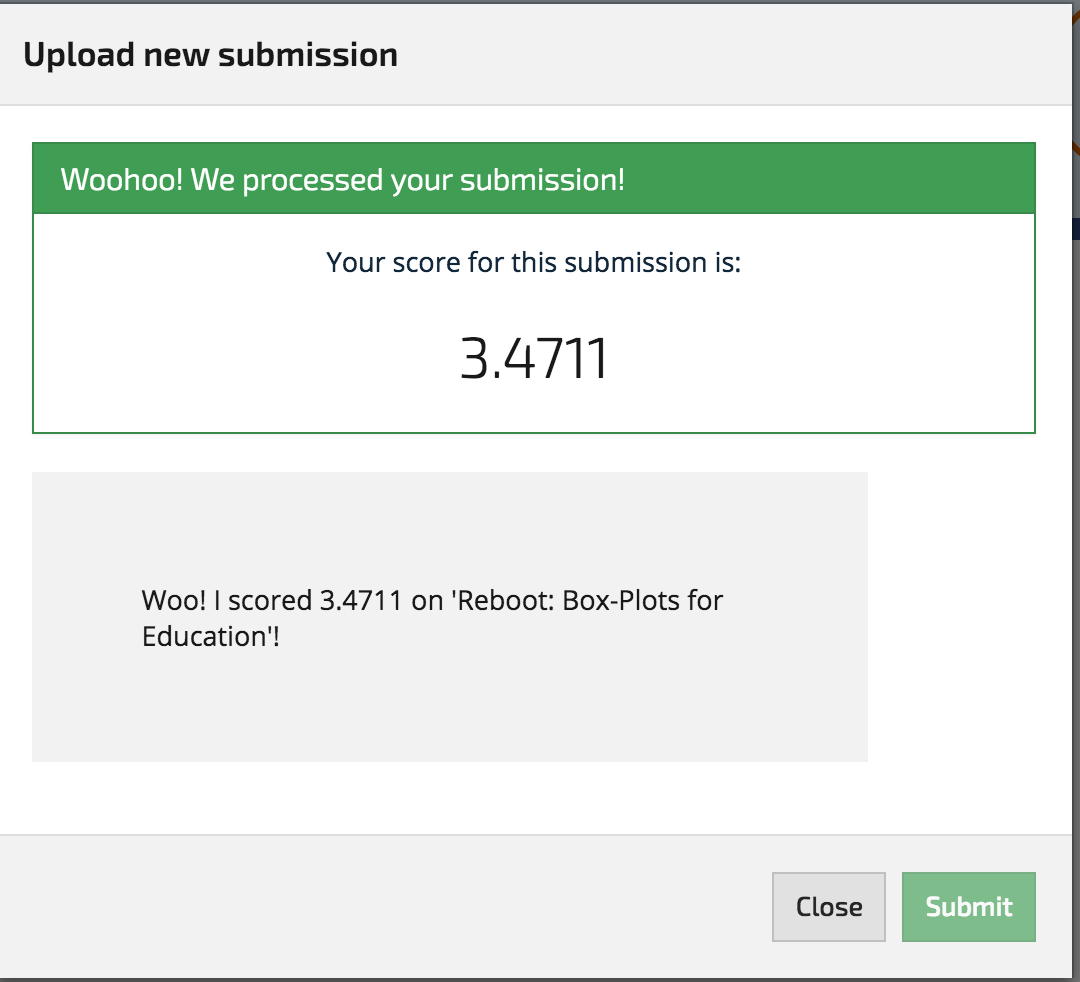

## Testing all the best models from Grid Search

### MultiNB

In [79]:
mnb_clf = MultiOutputClassifier(MultinomialNB(alpha=0.0001,fit_prior = True))
start = time.time()
mnb_clf.fit(prepared_data,target_104_data)
runtime_mnb = time.time()- start

In [81]:
mnb_predict_all = mnb_clf.predict_proba(prepared_F_test_data)

In [82]:
#create output file
write_predict_tocsv(mnb_predict_all, "mnbProbabs.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [96]:
gs_results.loc[len(gs_results)] = ["MultiOutputClassifier(MultiNaïveBayes)", "alpha=0.0001,fit_prior = True", 2.83, np.round(runtime_mnb,4)]
gs_results

,Model,Best Parameters,Accuracy,Runtime
0,Vanilla Logistic Regression,default,3.47,261.1875
1,MultiOutputClassifier(MultiNaïveBayes),"alpha=0.0001,fit_prior = True",2.83,47.3226


### Logistic Regression

In [83]:
lr_clf = MultiOutputClassifier(LogisticRegression(C=1.0,penalty='l1'))
start = time.time()
lr_clf.fit(prepared_data,target_104_data)
runtime_lr = time.time()- start

In [85]:
lr_predict_all = lr_clf.predict_proba(prepared_F_test_data)

In [86]:
#create output file
write_predict_tocsv(lr_predict_all, "lr_gs_Prob.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [97]:
gs_results.loc[len(gs_results)] = ["MultiOutputClassifier(Logistic Regression)", "C=1.0,penalty=l1", 2.11 , runtime_lr]
gs_results

,Model,Best Parameters,Accuracy,Runtime
0,Vanilla Logistic Regression,default,3.47,261.187500
1,MultiOutputClassifier(MultiNaïveBayes),"alpha=0.0001,fit_prior = True",2.83,47.322600
2,MultiOutputClassifier(Logistic Regression),"C=1.0,penalty=l1",2.11,325.732346


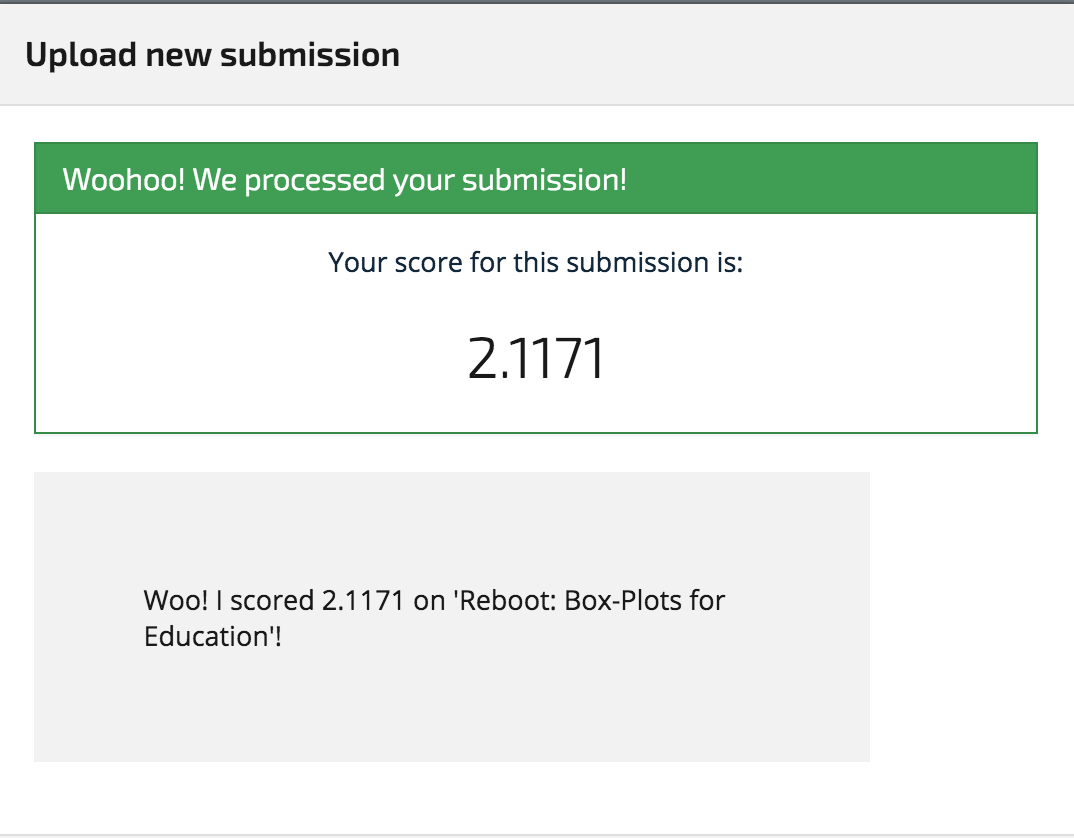

Our best score is not that great but it is a good start. We will work on it!

Since we have two imputation pipelines, we will impute our testing data on those pipelines before passing it for predictions

## Load the full test data

In [36]:
dd_test = load_data(path,"TestData.csv")
dd_test['index'] = dd_test['Unnamed: 0']

In [37]:
dd_test = dd_test.drop('Unnamed: 0', axis = 1)
dd_test.head()

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1,index
0,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN,180042
1,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN,28872
2,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN,186915
3,Professional Salaries,Bilingual Education,NaN,T-EL 2ND BIL,NaN,General,School,1.0,Instruction,NaN,NaN,69729.263191,NaN,NaN,General Fund,NaN,412396
4,Salaries for Support Personnel,Undistributed,NaN,CLERK III- SCH,NaN,General,School,1.0,School Leadership,NaN,NaN,29492.834215,NaN,NaN,General Fund,NaN,427740


In [38]:
dd_test = dd_test.drop_duplicates('index')
dd_test.shape

(50064, 17)

## Numerical pipeline

In [40]:
# Fit for DrivenData submission
num_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description','FTE',
                      'Function_Description','Facility_or_Department','Position_Extra','Total',
                      'Program_Description','Fund_Description','Text_1','index']
num_impute_attribs = ['FTE','Total']
datatype = np.dtype([('Object_Description',object),('Text_2',object),('SubFund_Description',object),('Job_Title_Description',object),('Text_3',object),('Text_4',object),('Sub_Object_Description',object),('Location_Description',object),('FTE',float),('Function_Description',object),('Facility_or_Department',object),('Position_Extra',object),('Total',float),('Program_Description',object),('Fund_Description',object),('Text_1',object),('index',int)])

num_impute_pipeline_t =  Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SelfImputer(num_impute_attribs,num_attribs,datatype,seed_strategy="most_frequent"))
    ])

num_impute_pipeline_t.fit(dd_test)
test_fin_num_imp = num_impute_pipeline_t.transform(dd_test)
test_fin_num_imp.head()

,FTE,Total,index
0,0.003183,0.002054,180042
1,0.002144,0.002053,28872
2,0.002861,0.002096,186915
3,0.002861,0.002111,412396
4,0.002861,0.002076,427740


## Categorical Pipeline

In [50]:
test_f_imp = cat_pipeline.transform(dd_test)

0    Student Meals/Room/Other nan nan nan nan nan L...
1    Extra Duty/Signing Bonus Pay nan nan CHEERLEAD...
2    Professional Salaries nan nan T-EL 1ST BIL nan...
3    Professional Salaries nan nan T-EL 2ND BIL nan...
4    Salaries for Support Personnel nan nan CLERK I...
dtype: object


In [51]:
test_f_vec = vect.transform(test_f_imp["All"]) #transforming test based on train fitted method

In [52]:
cat_tok_dd_test = pd.SparseDataFrame(test_f_vec, columns=vect.get_feature_names(), default_fill_value=0)
cat_tok_dd_test.shape

(50064, 427)

In [53]:
cat_tok_dd_test.head()

,60hrs,80hs,abatement,achiev,achievment,actually,actuary,adj,adjustme,administ,...,wingspread,wirelesscontvty,witness,women,worke,xerox,yard,zero,zone,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merge both data sets

In [55]:
prepared_F_test_data = pd.concat([test_fin_num_imp, cat_tok_dd_test], axis=1, join_axes=[cat_tok_dd_test.index])
prepared_F_test_data.shape

(50064, 430)

## Predict using Vanilla Logitistic Regression

In [100]:
##resutls comparison 
gs_results = pd.DataFrame(columns =['Model', 'Best Parameters', 'Multi-multiclass log loss', 'Runtime'])

In [59]:
# ran from cell 10.2.4
logreg_predict_all = logreg_clf.predict_proba(prepared_F_test_data)

In [60]:
#create output file
write_predict_tocsv(logreg_predict_all, "logregProbabs.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [101]:
gs_results.loc[len(gs_results)] = ["Vanilla Logistic Regression", "default", 3.47 , 261.1875]
gs_results

,Model,Best Parameters,Multi-multiclass log loss,Runtime
0,Vanilla Logistic Regression,default,3.47,261.1875


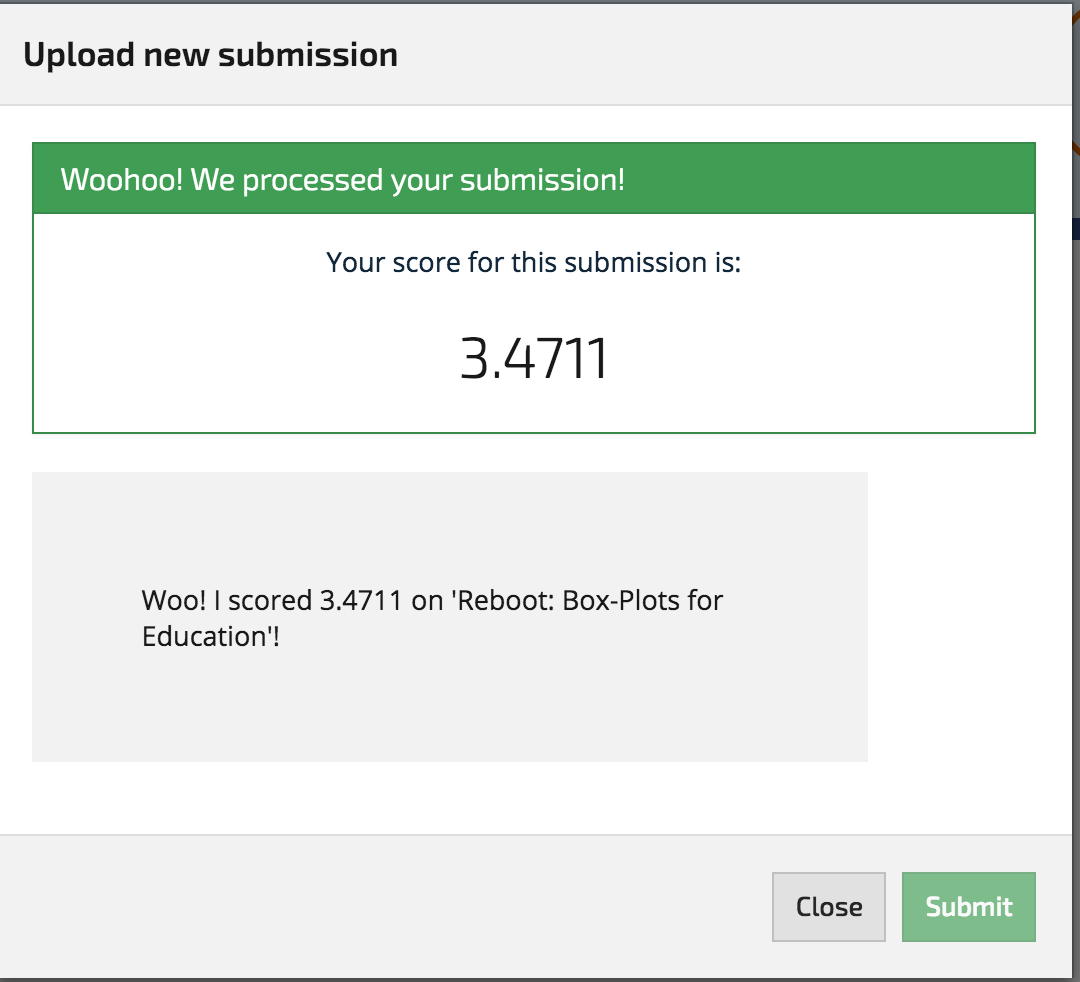

## Testing all the best models from Grid Search

### MultiNB

In [79]:
mnb_clf = MultiOutputClassifier(MultinomialNB(alpha=0.0001,fit_prior = True))
start = time.time()
mnb_clf.fit(prepared_data,target_104_data)
runtime_mnb = time.time()- start

In [81]:
mnb_predict_all = mnb_clf.predict_proba(prepared_F_test_data)

In [82]:
#create output file
write_predict_tocsv(mnb_predict_all, "mnbProbabs.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [102]:
gs_results.loc[len(gs_results)] = ["MultiOutputClassifier(MultiNaïveBayes)", "alpha=0.0001,fit_prior = True", 2.83, np.round(runtime_mnb,4)]
gs_results

,Model,Best Parameters,Multi-multiclass log loss,Runtime
0,Vanilla Logistic Regression,default,3.47,261.1875
1,MultiOutputClassifier(MultiNaïveBayes),"alpha=0.0001,fit_prior = True",2.83,47.3226


### Logistic Regression

In [83]:
lr_clf = MultiOutputClassifier(LogisticRegression(C=1.0,penalty='l1'))
start = time.time()
lr_clf.fit(prepared_data,target_104_data)
runtime_lr = time.time()- start

In [85]:
lr_predict_all = lr_clf.predict_proba(prepared_F_test_data)

In [86]:
#create output file
write_predict_tocsv(lr_predict_all, "lr_gs_Prob.csv", target_104_data.columns,
                    prepared_F_test_data['index'])

In [103]:
gs_results.loc[len(gs_results)] = ["MultiOutputClassifier(Logistic Regression)", "C=1.0,penalty=l1", 2.11 , runtime_lr]
gs_results

,Model,Best Parameters,Multi-multiclass log loss,Runtime
0,Vanilla Logistic Regression,default,3.47,261.187500
1,MultiOutputClassifier(MultiNaïveBayes),"alpha=0.0001,fit_prior = True",2.83,47.322600
2,MultiOutputClassifier(Logistic Regression),"C=1.0,penalty=l1",2.11,325.732346


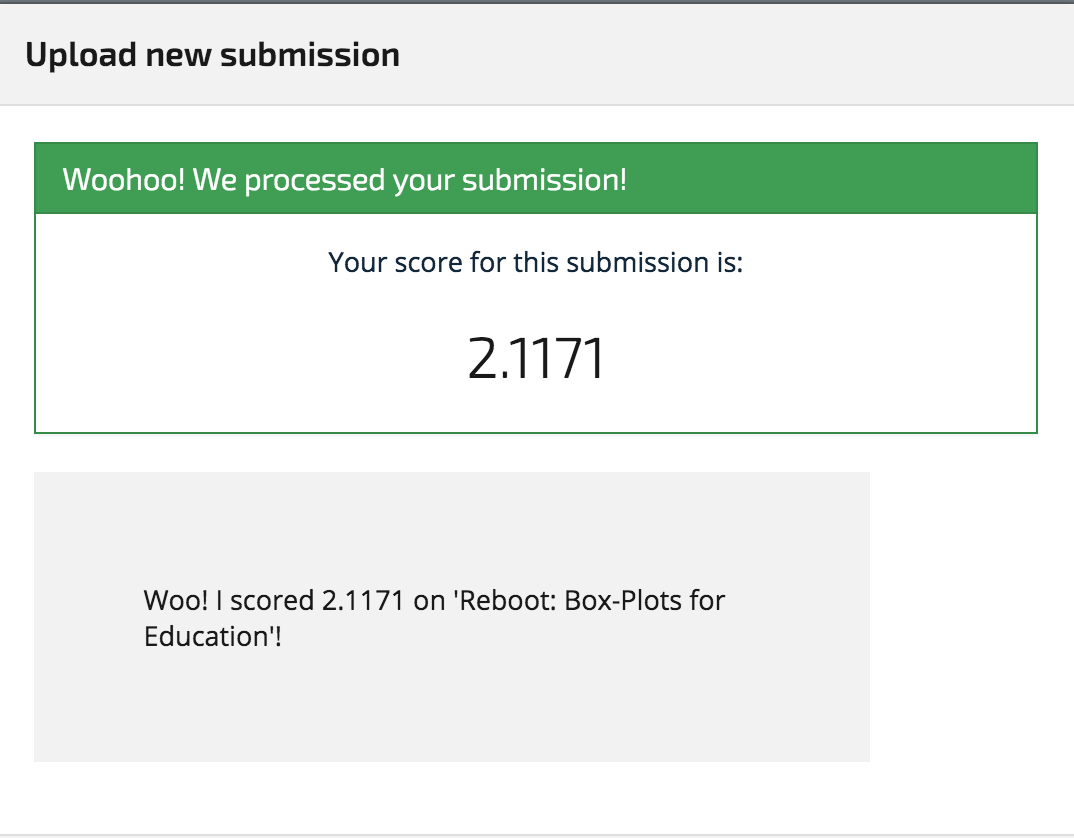

Our best score is not that great but it is a good start. We will work on it!